#  Searching for period spacing patterns

In this tutorial, we will analyse the spectrum of the $\gamma$ Dor star KIC7694191 as an example of how you can search for period spacing patterns with `morse`. It is assumed that you already did the frequency analysis of the lightcurve with your favourite tool (Period04, SigSpec, VARTOOLS...). In other words, we start from the list of peak frequencies. For this example, the frequencies were extracted from iterative pre-whitening method using ECHO ([Antoci et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.4040A/abstract)).

Note that frequencies must be in microHertz. If they are in cycles per day in your file, you may use `awk '{$N = $N / 0.0864} ; print' input.txt > output.txt` in a terminal for a quick conversion, where N is the number of the column to be converted. 

First, let's load the list of frequencies into a Spectrum object.

In [2]:
import morse as ms

spectrum = ms.Spectrum() # Initialises an instance of Spectrum object
spectrum.load(path='kic7694191_all_alpha0.75.dat', colfreqs=1, colerrs=2, colamps=3)

By default, the frequencies are read from the 1st column of the file. However, in our file, the frequencies are in the 2nd column so we use the argument `colfreqs=1`. Additionally, since they are available, we want to load the frequency errors and amplitudes. This is done by giving the column indices to `load()` with the arguments `colerrs` and `colamps`.

Now that we loaded the data, let's have a quick look at the oscillation spectrum.

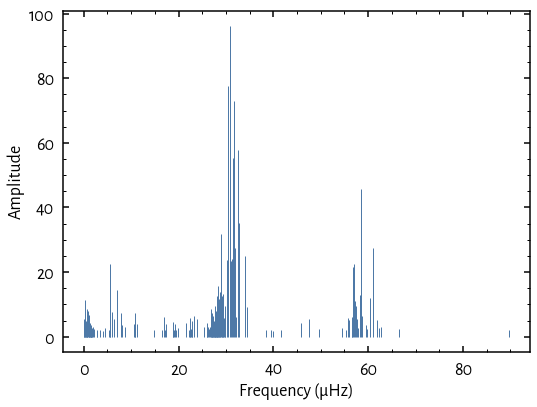

In [3]:
spectrum.plot()

Three frequency groups are visible around 5, 30 and 60 µHz. It is common to find groupings in the spectrum of $\gamma$ Dor stars (see Fig. 5 of [Li et al. 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.3586L/)). Analysing them separately is usually a good strategy as, generally, modes of same ID are in one group only. For instance, let's focus on the group of peaks around 30 µHz. We can call `filter()` to isolate this part of the spectrum and put it into a new Spectrum object.

In [4]:
fgroup1 = spectrum.filter(freqmin=25, freqmax=35)

The next step is to pick the ID $(m,k)$ of the modes to be identified, where $m$ is the azimutal order and $k$ is the ordering index used by [Lee & Saio 1997](https://ui.adsabs.harvard.edu/abs/1997ApJ...491..839L/abstract). For *g* modes, $k = \ell + |m| \geq 0$. We will try dipole prograde modes since they are the most observed in $\gamma$ Dors.

In [5]:
m = -1       # m < 0 --> prograde modes
k = 0        # l = k + |m| = 1 --> dipole modes

We also have to delimit the 2D parameter space (rotation frequency $\nu_{\rm rot}$, buoyancy radius $P_0$) we would like to explore and with which density. Note that the denser the grid is, the longer the computations will be. 

In [6]:
nurot_vect = np.linspace(0., 25, 2000)   # in µHz
f0_vect = np.arange(150, 400, 2)        # 1/P0 in µHz --> P0 between 2500 and 6666 s.

Now that everything is set up, we can search for a possible period spacing pattern of $(m=-1,k=0)$ modes by computing the ID map.

In [7]:
idmap = ms.IDMap(fgroup1, m, k, nurot_vect, f0_vect)

[===============]  100.0% Computing the ID map...



Let's have a look at the computed map. 

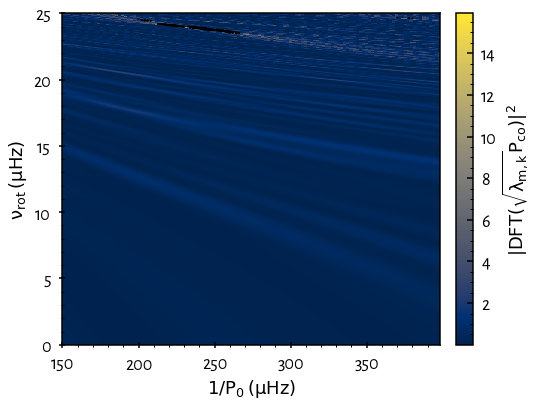

In [8]:
idmap.plot()

There is a region of high PSD (power spectral density) around $(\nu_{\rm rot} = 24~{\rm \mu Hz}$, $1/P_0 = 230~{\rm \mu Hz}$). Let's zoom in on this region and increase the resolution of the grid.

[===============]  100.0% Computing the ID map...



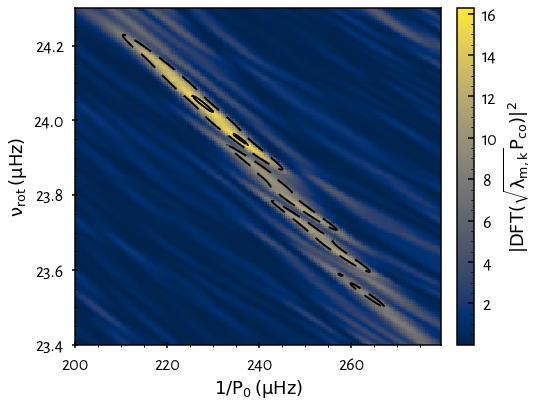

In [9]:
nurot_vect = np.linspace(23.4, 24.3, 200)
f0_vect = np.arange(200, 280, 0.5) 
idmap = ms.IDMap(fgroup1, m, k, nurot_vect, f0_vect)
idmap.plot()

Dashed and solid lines are contours at 50% and 90% of the maximum of PSD, respectively. To make sure this peak is statistically significant we can check the attributes `flag_detection`, `psd_max` and `psd_threshold`.

In [10]:
print(f"flag_detection = {idmap.flag_detection}\n"+
      f"PSD max = {idmap.psd_max:.2f}, PSD threshold = {idmap.psd_threshold:.2f}")

flag_detection = True
PSD max = 16.26, PSD threshold = 7.82


Here, `flag_detection` is `True` meaning that the maximum of PSD (`psd_max`) is strictly superior to the detection threshold (`psd_threshold`). A peak of PSD has less than 1% chance of being due to pure noise if it is above this detection threshold.

In other words, we found a period spacing pattern! We can check the attributes `nurot` and `buoyancy_radius` to get a first estimate of the rotation frequency $\nu_{\rm rot}$ and buoyancy radius $P_0$.

In [11]:
print(f"Rotation frequency = {idmap.nurot:.2f} µHz\n"+
      f"Buoyancy radius = {idmap.buoyancy_radius:.0f} s")

Rotation frequency = 24.05 µHz
Buoyancy radius = 4396 s


These values corresponds to the maximum of PSD in the ID map.

A good way to visualise the pattern is to plot the echelle diagram of the spectrum stretched using the parameters found with the ID map.

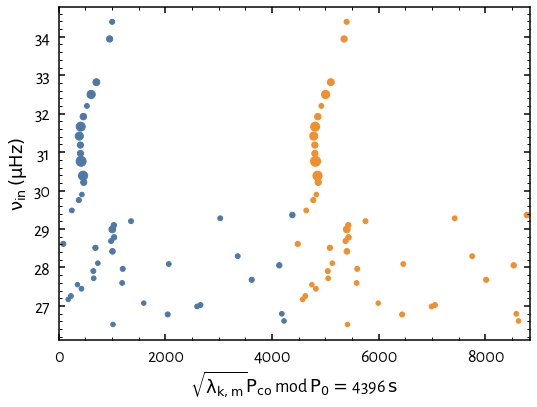

In [12]:
idmap.get_echelle_diagram()
idmap.echelle_diagram.plot()

The echelle diagram is plotted twice for clarity. Marker size is representative of the frequency peak amplitudes in the oscillation spectrum (if this information is available). 

The period spacing pattern we have found appears as a relatively clear vertical ridge in the diagram. Some peaks at lower frequencies seems not to belong to the ridge. They are  all of low amplitude and may be either spurious frequencies or modes of different $(m,k)$. Also, there is a deviation from regularity around ~29.3 µHz, which could corresponds to a resonance of pure inertial modes in the convective core with $(m=-1,k=0)$ modes (see [Ouazzani et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A..49O/)).

We now have estimates for $\nu_{\rm rot}$ and $P_0$. They can be used to search for other possible patterns with echelle diagrams. For instance, let's look at the frequency group around 60 µHz.

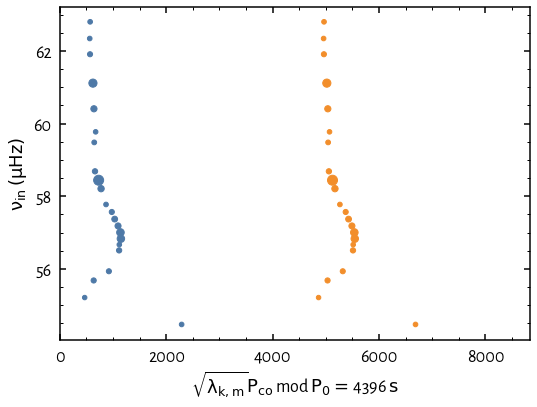

In [13]:
fgroup2 = spectrum.filter(freqmin=54, freqmax=63)
ed = ms.EchelleDiagram(fgroup2, m=-2, k=0, nurot=idmap.nurot, 
                       buoyancy_radius=idmap.buoyancy_radius)
ed.plot()

We found a period spacing pattern this time made of $(m=-2,k=0)$ modes!